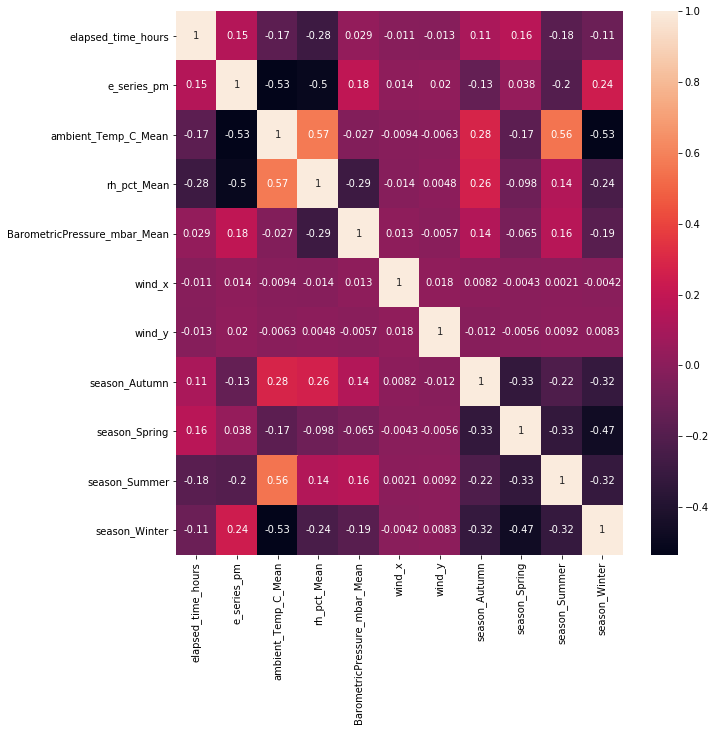

In [2]:
import openpyxl
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor

from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

from matplotlib import pyplot as plt
import datetime
import math
import pandas as pd
from scipy import stats
import seaborn as sn

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# Read in the dataframe
dataframe = pd.read_pickle('merged_dataset_elasped_time_hours_added.pkl')
dataframe = dataframe.dropna()

# Convert to numpy array
# Seperate the target 
# Remove the target from the DATA matrix
DATA = dataframe.to_numpy()
target = DATA[:,12].reshape(-1,1)
DATA = np.delete(DATA, 12, 1)
# Delete the dates
DATA = np.delete(DATA, 0, 1)
# Separate the elasped time (hours)
# Remove from the DATA matrix
hours = DATA[:,0]
DATA = np.delete(DATA, 0, 1)

# Display the dataframe
dataframe

dataframe_new = dataframe.drop(columns=['reference_pm'])
corrMatrix = dataframe_new.corr()
plt.subplots(figsize=(10,10))
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [72]:
# Split the data set into two halves, getting matrices a and b
A, B = np.split(np.delete(DATA, len(DATA)-1, 0), [int(0.10 * len(DATA))])
# Add the last odd row to b
B = np.vstack([B, DATA[:][len(DATA)-1]])
# Split the target
a, b = np.split(np.delete(target, len(target)-1, 0), [int(0.10 * len(target))])
b = np.vstack([b, target[:][len(target)-1]])
# Split the hours
a_hours, b_hours = np.split(np.delete(hours, len(hours)-1, 0), [int(0.10 * len(hours))])
hours[:][len(hours)-1]
b_hours = np.append(b_hours, hours[:][len(hours)-1])
print(A.shape, B.shape, a.shape, b.shape, a_hours.shape, b_hours.shape)

# Split the A matrix into training and testing matrices
# A_train, A_test, target_train, target_test = train_test_split(A, a, random_state=0)
# Perfrom decision tree regression on the A matrice
random_forest = RandomForestRegressor(n_estimators=1000, criterion='mse', min_samples_leaf=5, random_state=0).fit(A, a.flatten())
print("Training set score: {:0.6f}".format(random_forest.score(A, a)))
print('MAE: {:0.4f}'.format(metrics.mean_absolute_error(a, random_forest.predict(A))))
R2 = metrics.r2_score(a, random_forest.predict(A))
adjusted_R2 = 1 - ((1-R2**2)*(np.size(A[:,0],0)-1))/(np.size(A[:,0],0) - np.size(A[:0],1) - 1)
print('R2: {:0.4f}'.format(R2))
print('adjusted-R2: {:0.4f}'.format(adjusted_R2))
print('Estimator feature strengths: {}'.format(random_forest.feature_importances_))

(1199, 10) (10800, 10) (1199, 1) (10800, 1) (1199,) (10800,)
Training set score: 0.944512
MAE: 0.9991
R2: 0.9445
adjusted-R2: 0.8912
Estimator feature strengths: [0.95956186 0.00857763 0.00804037 0.00976098 0.00638314 0.00767603
 0.         0.         0.         0.        ]


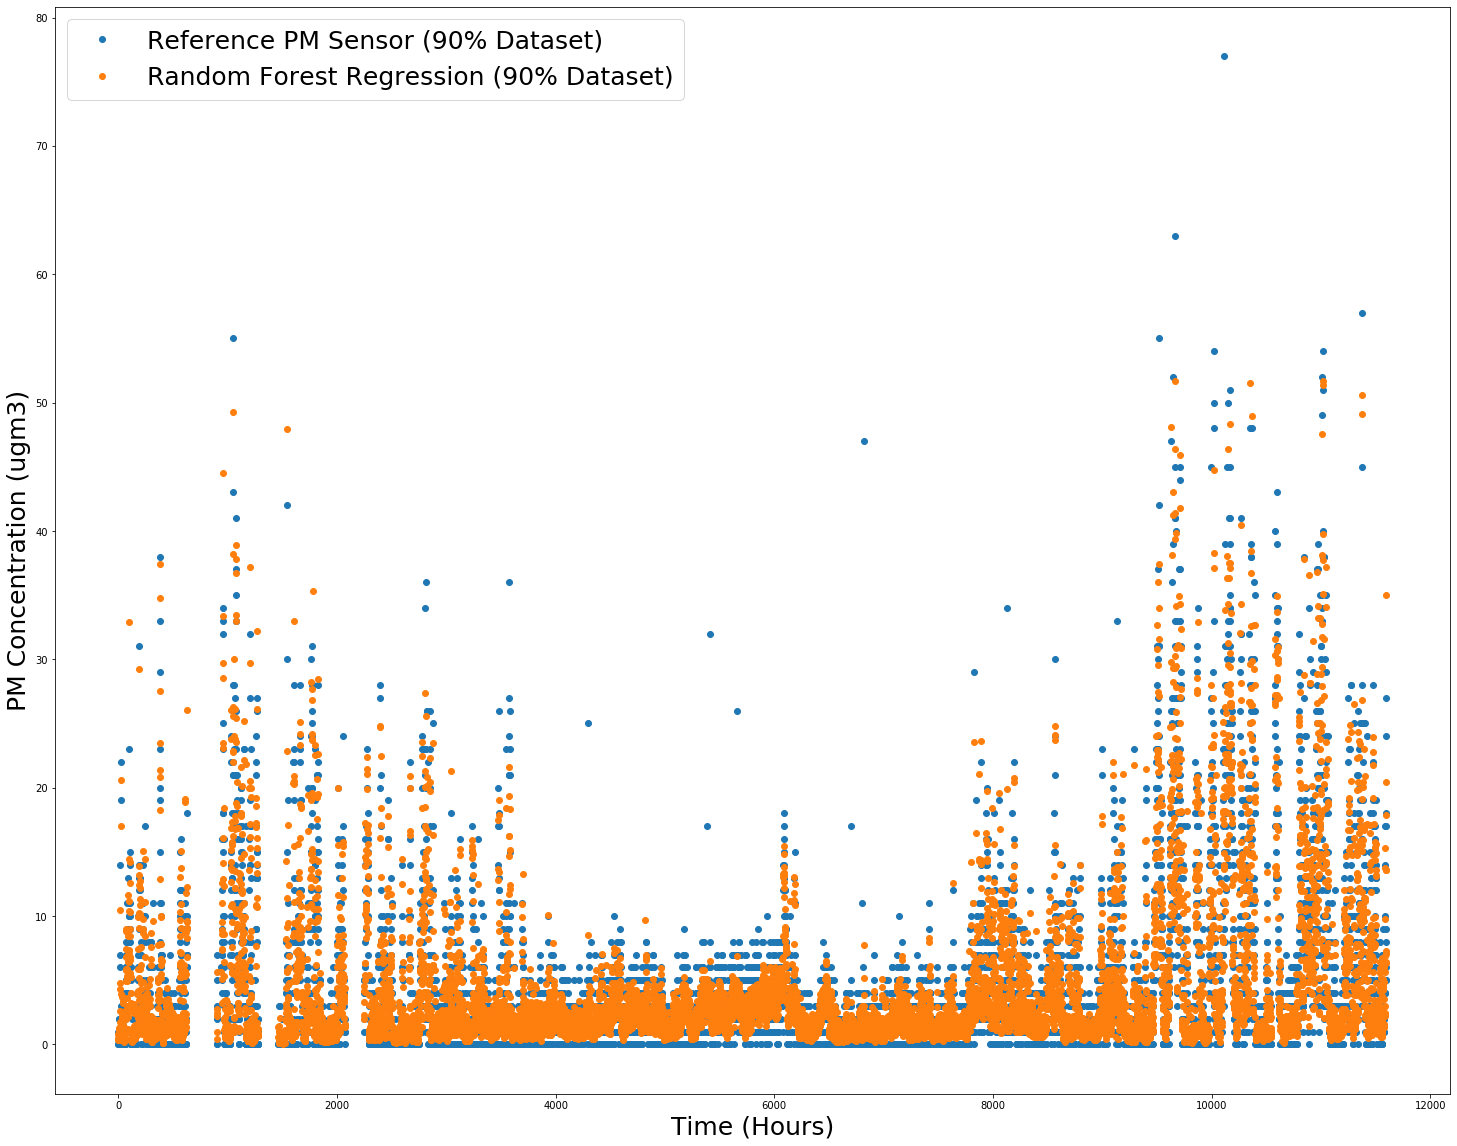

In [69]:
# Plot the time series graph
plt.figure(figsize=(25,20))
plt.plot(a_hours, a, 'o',label="Reference PM Sensor (90% Dataset)")
plt.plot(a_hours, random_forest.predict(A), 'o',label="Random Forest Regression (90% Dataset)")
plt.xlabel('Time (Hours)', fontsize=25)
plt.ylabel('PM Concentration (ugm3)', fontsize=25)
plt.legend(loc='best', fontsize=25)

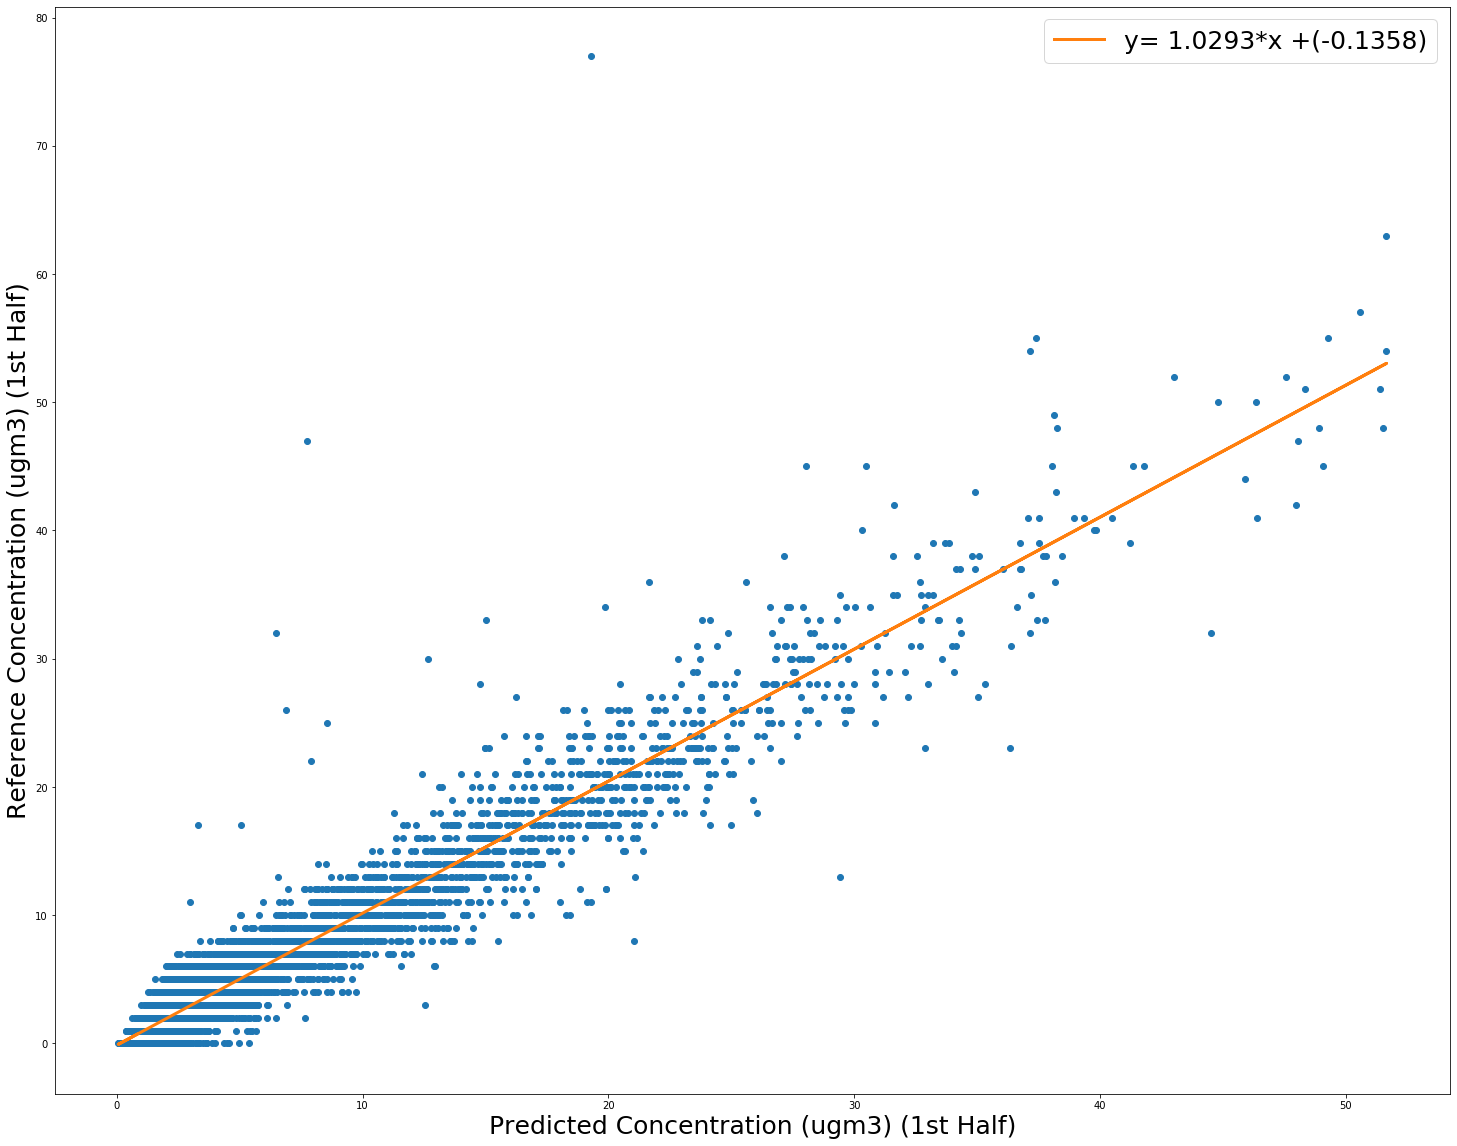

In [70]:
# Calculate a regression line
linear_regression = LinearRegression().fit(random_forest.predict(A).reshape(-1,1), a)
# Plot the values graph with the regression line
plt.figure(figsize=(25,20))
plt.plot(random_forest.predict(A).reshape(-1,1), a, 'o')
plt.plot(random_forest.predict(A), 
         linear_regression.predict(random_forest.predict(A).reshape(-1,1)),
         label='y= {:0.4f}*x +({:0.4f})'.format(linear_regression.coef_[0][0], linear_regression.intercept_[0]),
         linewidth=3)
plt.xlabel('Predicted Concentration (ugm3) (1st Half)', fontsize=25)
plt.ylabel('Reference Concentration (ugm3) (1st Half)', fontsize=25)
plt.legend(loc='best', fontsize=25)

In [75]:
print('MAE: {:0.4f}'.format(metrics.mean_absolute_error(b, random_forest.predict(B))))
R2 = metrics.r2_score(b, random_forest.predict(B))
adjusted_R2 = 1 - ((1-R2**2)*(np.size(B[:,0],0)-1))/(np.size(B[:,0],0) - np.size(B[:0],1) - 1)
print('R2: {:0.4f}'.format(R2))
print('adjusted-R2: {:0.4f}'.format(adjusted_R2))
print('Estimator feature strengths: {}'.format(random_forest.feature_importances_))

MAE: 1.7494
R2: 0.7916
adjusted-R2: 0.6263
Estimator feature strengths: [0.95956186 0.00857763 0.00804037 0.00976098 0.00638314 0.00767603
 0.         0.         0.         0.        ]


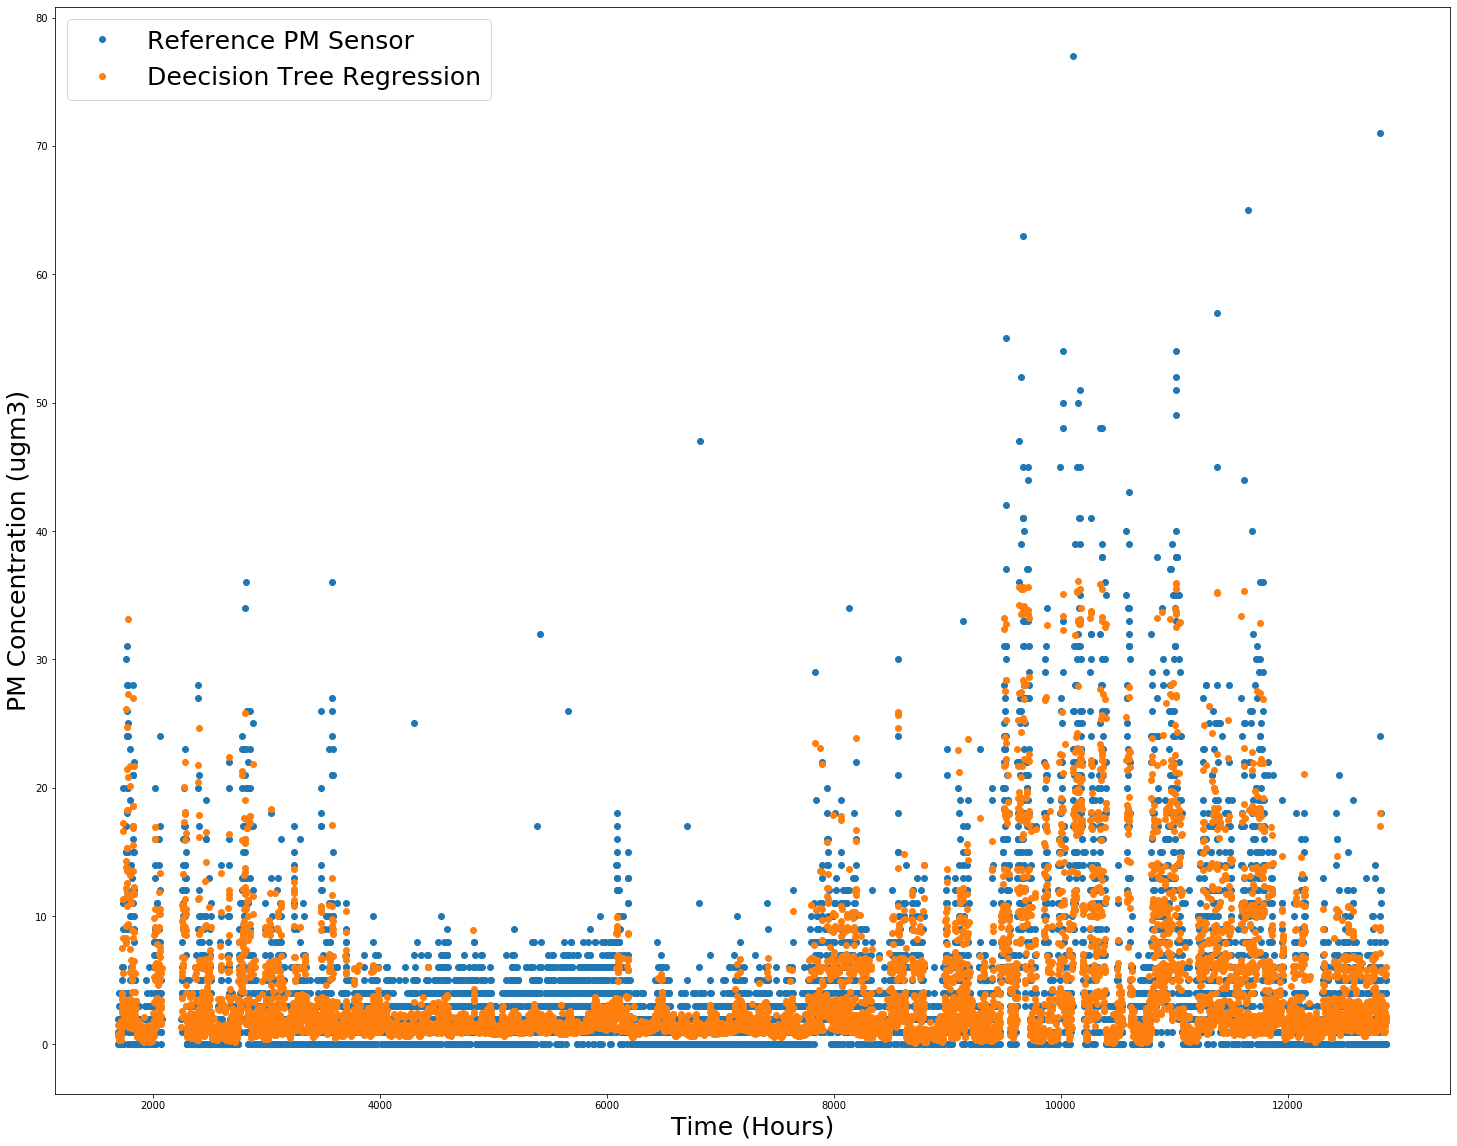

In [77]:
# Plot the time series graph
plt.figure(figsize=(25,20))
plt.plot(b_hours, b, 'o',label="Reference PM Sensor")
plt.plot(b_hours, random_forest.predict(B), 'o',label="Deecision Tree Regression")
plt.xlabel('Time (Hours)', fontsize=25)
plt.ylabel('PM Concentration (ugm3)', fontsize=25)
plt.legend(loc='best', fontsize=25)

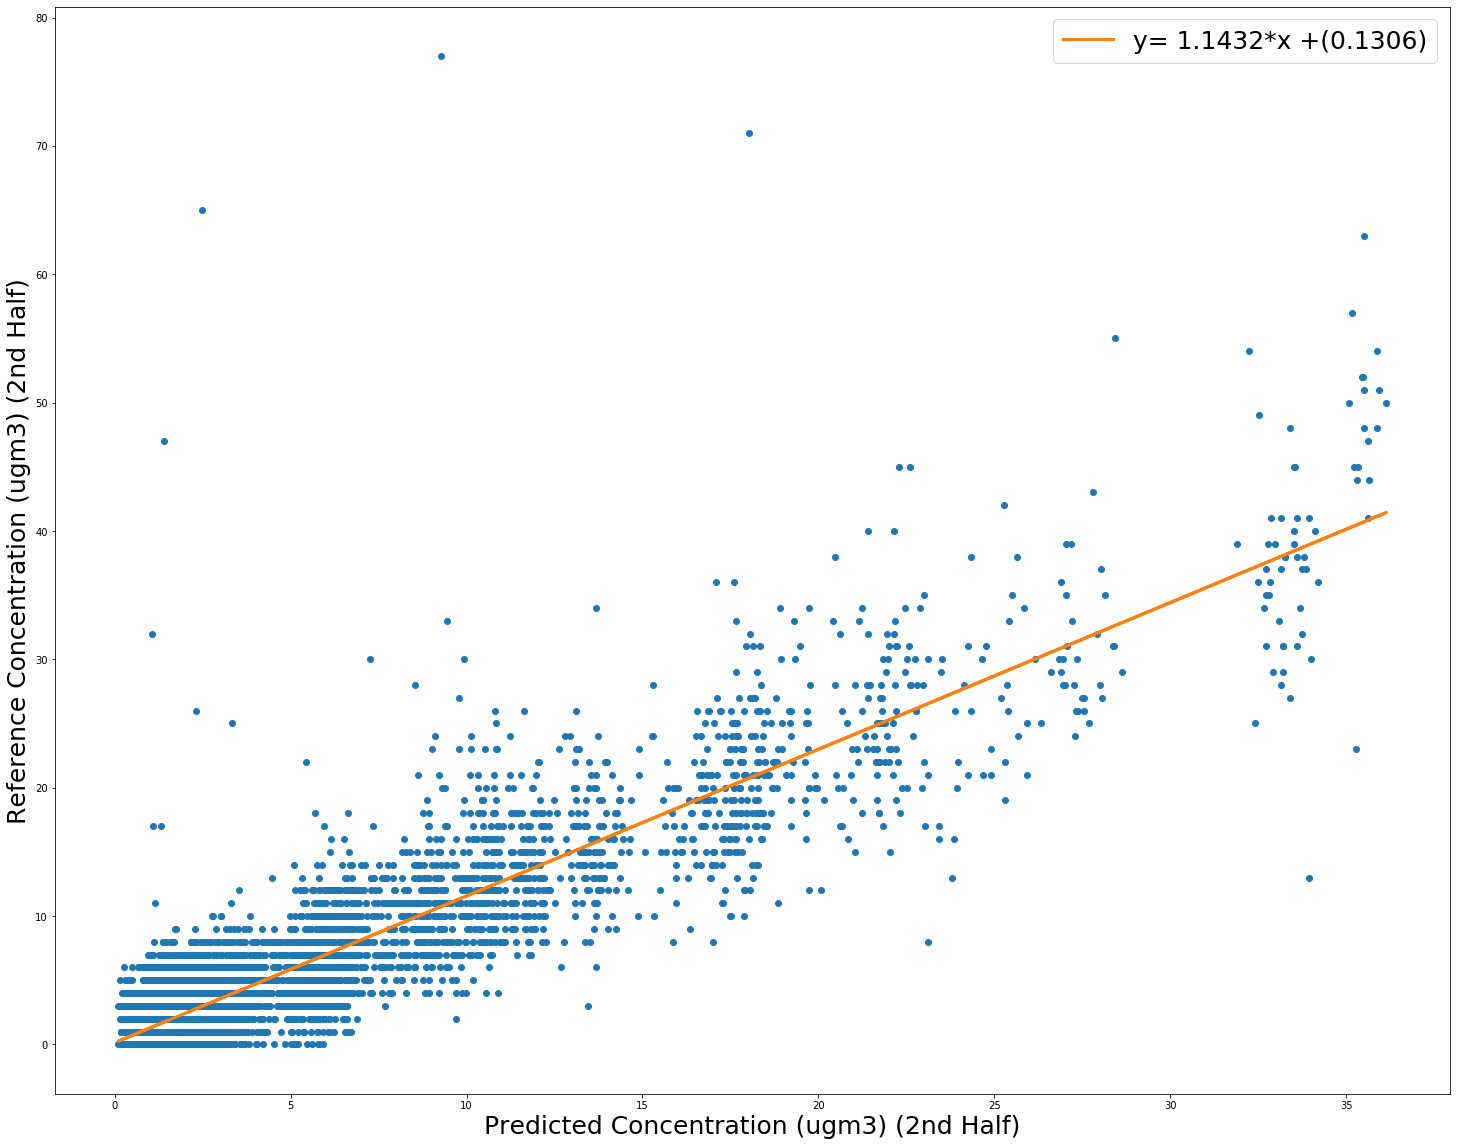

In [78]:
# Calculate a regression line
linear_regression = LinearRegression().fit(random_forest.predict(B).reshape(-1,1), b)
# Plot the values graph with the regression line
plt.figure(figsize=(25,20))
plt.plot(random_forest.predict(B).reshape(-1,1), b, 'o')
plt.plot(random_forest.predict(B), 
         linear_regression.predict(random_forest.predict(B).reshape(-1,1)),
         label='y= {:0.4f}*x +({:0.4f})'.format(linear_regression.coef_[0][0], linear_regression.intercept_[0]),
         linewidth=3)
plt.xlabel('Predicted Concentration (ugm3) (2nd Half)', fontsize=25)
plt.ylabel('Reference Concentration (ugm3) (2nd Half)', fontsize=25)
plt.legend(loc='best', fontsize=25)